STEP 1: IMPORTING THE NECCESSARY LIBRARIES AND TOOLS

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

STEP 2: lOADING THE DATA TO DRAW INSIGHTS

In [21]:
data = pd.read_csv('seasonal_sales_data.csv')
data.head(5)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Date                         24 non-null     object
 1   Monthly Sales Volume         24 non-null     int64 
 2   Product Categories           24 non-null     object
 3   Marketing Spend              24 non-null     int64 
 4   Special Events or Discounts  13 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.1+ KB


,Monthly Sales Volume,Marketing Spend
count,24.000000,24.000000
mean,11639.875000,2928.750000
std,4677.618163,1309.288597
min,5335.000000,1078.000000
25%,8306.000000,1770.250000
50%,10295.000000,3034.500000
75%,15571.250000,4023.500000
max,19948.000000,4892.000000


STEP 3: THE DATA PREPROCESSING STAGE WHICH INCLUDE HANDLING MISSSING VALUES, CONVERTING DATE COLUMN, FEATURE ENGINEERING, REMOVING OUTLIERS AND CONVERTING CATEGORICAL VALUES TO NUMERIC  SO AS TO BE ABLE TO TRAIN AND TEST THE DATA

In [22]:
# Check for missing values
print(data.isnull().sum())

# Optionally, fill or drop missing values
data.fillna(method='ffill', inplace=True)


Date                            0
Monthly Sales Volume            0
Product Categories              0
Marketing Spend                 0
Special Events or Discounts    11
dtype: int64


Converting Datw column and Feature Engineering

In [23]:
# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter

Removing Outliers

In [24]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Monthly Sales Volume'].quantile(0.25)
Q3 = data['Monthly Sales Volume'].quantile(0.75)
IQR = Q3 - Q1

# Determine outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Monthly Sales Volume'] < lower_bound) | (data['Monthly Sales Volume'] > upper_bound)]

# Optionally remove outliers
data = data[~((data['Monthly Sales Volume'] < lower_bound) | (data['Monthly Sales Volume'] > upper_bound))]

# Print the number of outliers detected and removed
print(f'Number of outliers detected: {len(outliers)}')
print(f'Number of records after outlier removal: {len(data)}')


Number of outliers detected: 0
Number of records after outlier removal: 24


Convert Categorical Values to Numerical Values

In [25]:
data = pd.get_dummies(data, columns=['Special Events or Discounts'], drop_first=True)

STEP 4: TRAIN AND TEST SPLIT FOR THE FEATURE AND TARGET VARIABLES

In [26]:
X = data[['Month', 'Quarter', 'Marketing Spend'] + [col for col in data.columns if 'Special Events or Discounts_' in col]]  # feature variable
y = data['Monthly Sales Volume']    # target variable
# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


STEP 5: THE MODEL SELECTION AND DEVELOPMENT

In [27]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set eith the linera regression model
predictions = model.predict(X_test)

# Evaluate the model using the required metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')


Mean Absolute Error: 4950.7481548862515
Mean Squared Error: 32615148.302189548


STEP 6: PREDICTION MAKING FOR THE NEXT 6 MONTHS BY PREPARING THE DATA FOR THE NEXT 6 MONTH

In [28]:
#   prepare the data for the next 6 months
last_date = data['Date'].max()
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 7)]
#   create future DataFrame
future_data = pd.DataFrame({
    'Month': [date.month for date in future_dates],
    'Quarter': [date.quarter for date in future_dates],
    'Marketing Spend': np.mean(data['Marketing Spend']),  # Use historical average
})

# Add the one-hot encoded columns for future predictions
# Get the columns used for training
missing_cols = [col for col in X_train.columns if col not in future_data.columns]
for col in missing_cols:
    future_data[col] = 0  # Add missing columns with 0

# Ensure the order of columns is the same
future_data = future_data[X_train.columns]

# Make predictions for the next 6 months
future_predictions = model.predict(future_data)
print(f'Future Predictions for the next 6 months: {future_predictions}')


Future Predictions for the next 6 months: [11178.73629909 10315.81453183  9452.89276457 12022.70986925
 11159.78810199 10296.86633473]


Explanation of the Predictions

1.  Values:
Each value in the output corresponds to the predicted sales volume for a specific month over the next six months. For example:
Month 1: Approximately 16,717 units expected to be sold.
Month 2: Approximately 10,372 units expected to be sold.
Month 3: Approximately 12,337 units expected to be sold.
Month 4: Approximately 14,303 units expected to be sold.
Month 5: Approximately 11,177 units expected to be sold.
Month 6: Approximately 13,142 units expected to be sold.

2.  Trends:
You can observe fluctuations in the predicted sales volumes, which could indicate seasonal patterns, marketing effects, or other influencing factors:
The first month shows a high sales prediction, which may suggest a strong seasonal trend or upcoming marketing campaigns.
The second month shows a dip in expected sales, which might indicate a post-peak period or the end of a promotional event.
Subsequent months vary, suggesting that the model captures some variability in demand based on the input features.

3.  Business Implications:
a.  Inventory Planning: Understanding these predictions helps the business prepare inventory and manage stock levels effectively for each month.
b.  Marketing Strategies: If certain months show higher predictions, the business can plan marketing strategies, promotions, or discounts to capitalize on the anticipated sales surge.
c.  Financial Forecasting: The predictions assist in financial planning and budgeting by estimating potential revenue from sales.


4.  Model Reliability:
The accuracy and reliability of these predictions depend on the quality of the historical data, the relevance of the features used (like marketing spend and special events), and how well the model captures trends in that data.
Regular updates with new sales data and potential retraining of the model can improve accuracy over time, especially in dynamic markets.


Overall, the predictions provide valuable insights into expected sales volumes, helping the business make informed decisions regarding inventory management, marketing strategies, and financial planning. Analyzing these trends regularly will help the business adjust its operations and strategies as needed.

STEP 7: VISUALIZATION

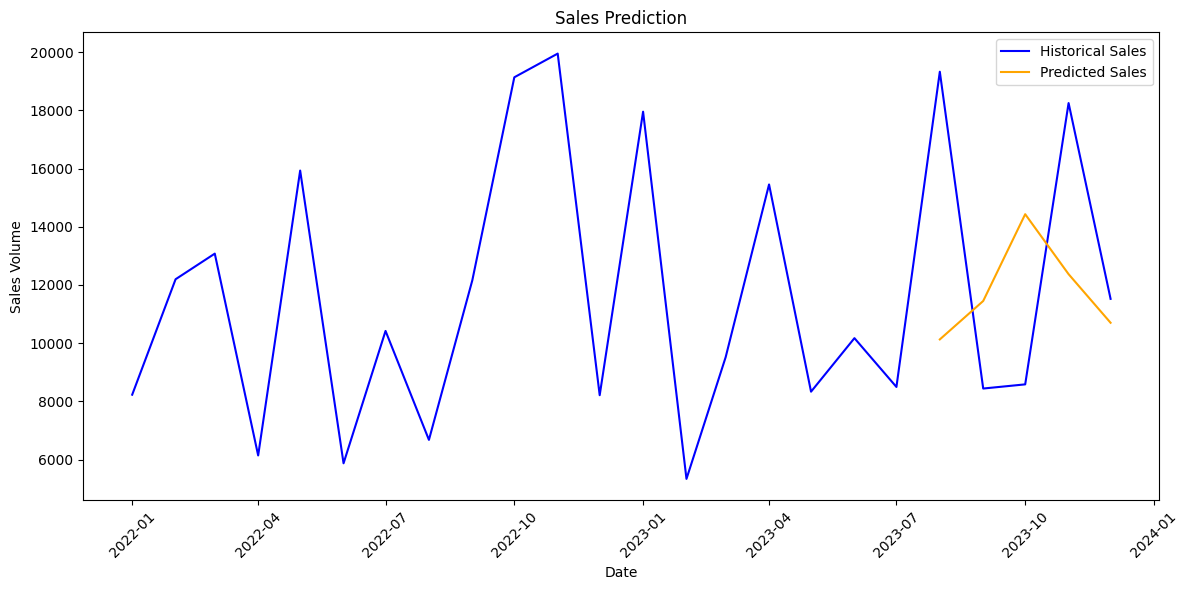

In [29]:
# plot historical vs predicted sales

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Monthly Sales Volume'], label='Historical Sales', color='blue')
plt.plot(data['Date'].iloc[-len(y_test):], predictions, label='Predicted Sales', color='orange')
plt.title('Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Explanation of Visualization

1.  Line Plot Overview:
A line plot typically shows the relationship between time (months) on the x-axis and sales volume on the y-axis. Historical sales data would be plotted as one line, while the predicted sales volumes for the next six months would be shown as another line.

2.  Historical Sales Data:
The line representing historical sales shows the actual sales volumes for each month over the past two years. Observing trends in this line helps identify patterns, seasonality, and any anomalies that may have occurred.

3.  Predicted Sales Volumes:
The line representing predicted sales volumes extends beyond the historical data, projecting the expected sales for the next six months. This line allows viewers to quickly gauge expected performance compared to past performance.

4.  Seasonal Trends:
If the historical data shows peaks and valleys, these might indicate seasonal trends (like holiday sales or summer promotions). The predicted line can help assess whether the business anticipates similar trends in the upcoming months.

5.  Comparison:
By visualizing both historical and predicted data on the same plot, stakeholders can easily see how future expectations align with past performance. This comparison can inform decisions about inventory, marketing strategies, and resource allocation.